In [1]:
import os
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import seaborn as sns
import scipy.sparse as sp
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

sc.settings.verbosity = 0
sc.settings.set_figure_params(dpi=300, dpi_save=500)
from matplotlib import rcParams
rcParams["figure.dpi"] = 300
rcParams["savefig.dpi"] = 500

In [2]:
data_dir = '../../../Data/Spatial/Transcriptomics/STARmap_V1_Wang2018/'
read_dir = data_dir + 'visual_1020/20180505-BY3_1kgenes/'
if not os.path.exists(data_dir + 'processed/'):
    os.makedirs(data_dir + 'processed/')

In [3]:
data_mtx = pd.read_csv(read_dir + 'starmap29930089_visual1020_by3_2_exp.csv', header=0, index_col=0)
# data_mtx

In [4]:
meta_data = pd.read_csv(read_dir + 'starmap29930089_visual1020_by3_2_metadata.csv', header=0, index_col='CellID')
# meta_data

In [5]:
adata = ad.AnnData(X=sp.csr_matrix(data_mtx))
adata.obs_names = data_mtx.index
adata.var_names = data_mtx.columns

meta_data = meta_data.loc[adata.obs_names]
adata.obs['clusterid'] = meta_data['ClusterID']
adata.obs['celltype'] = meta_data['ClusterName']
adata.obsm['spatial'] = np.column_stack((meta_data['Centroids_Y'], meta_data['Centroids_X']))

adata

AnnData object with n_obs × n_vars = 1549 × 1020
    obs: 'clusterid', 'celltype'
    obsm: 'spatial'

In [6]:
adata = adata[~(adata.obs['celltype'].isna() | (adata.obs['celltype'] == 'missing')), :]
labels = pd.read_csv(read_dir + 'layer_labels.csv', header=0, index_col=None)
adata.obs['layer'] = list(labels['label'])

adata

AnnData object with n_obs × n_vars = 1207 × 1020
    obs: 'clusterid', 'celltype', 'layer'
    obsm: 'spatial'

In [7]:
# adata.write_h5ad(data_dir + 'processed/STARmap_V1Cortex.h5ad')

In [8]:
adata = ad.read_h5ad(data_dir + 'processed/STARmap_V1Cortex.h5ad')

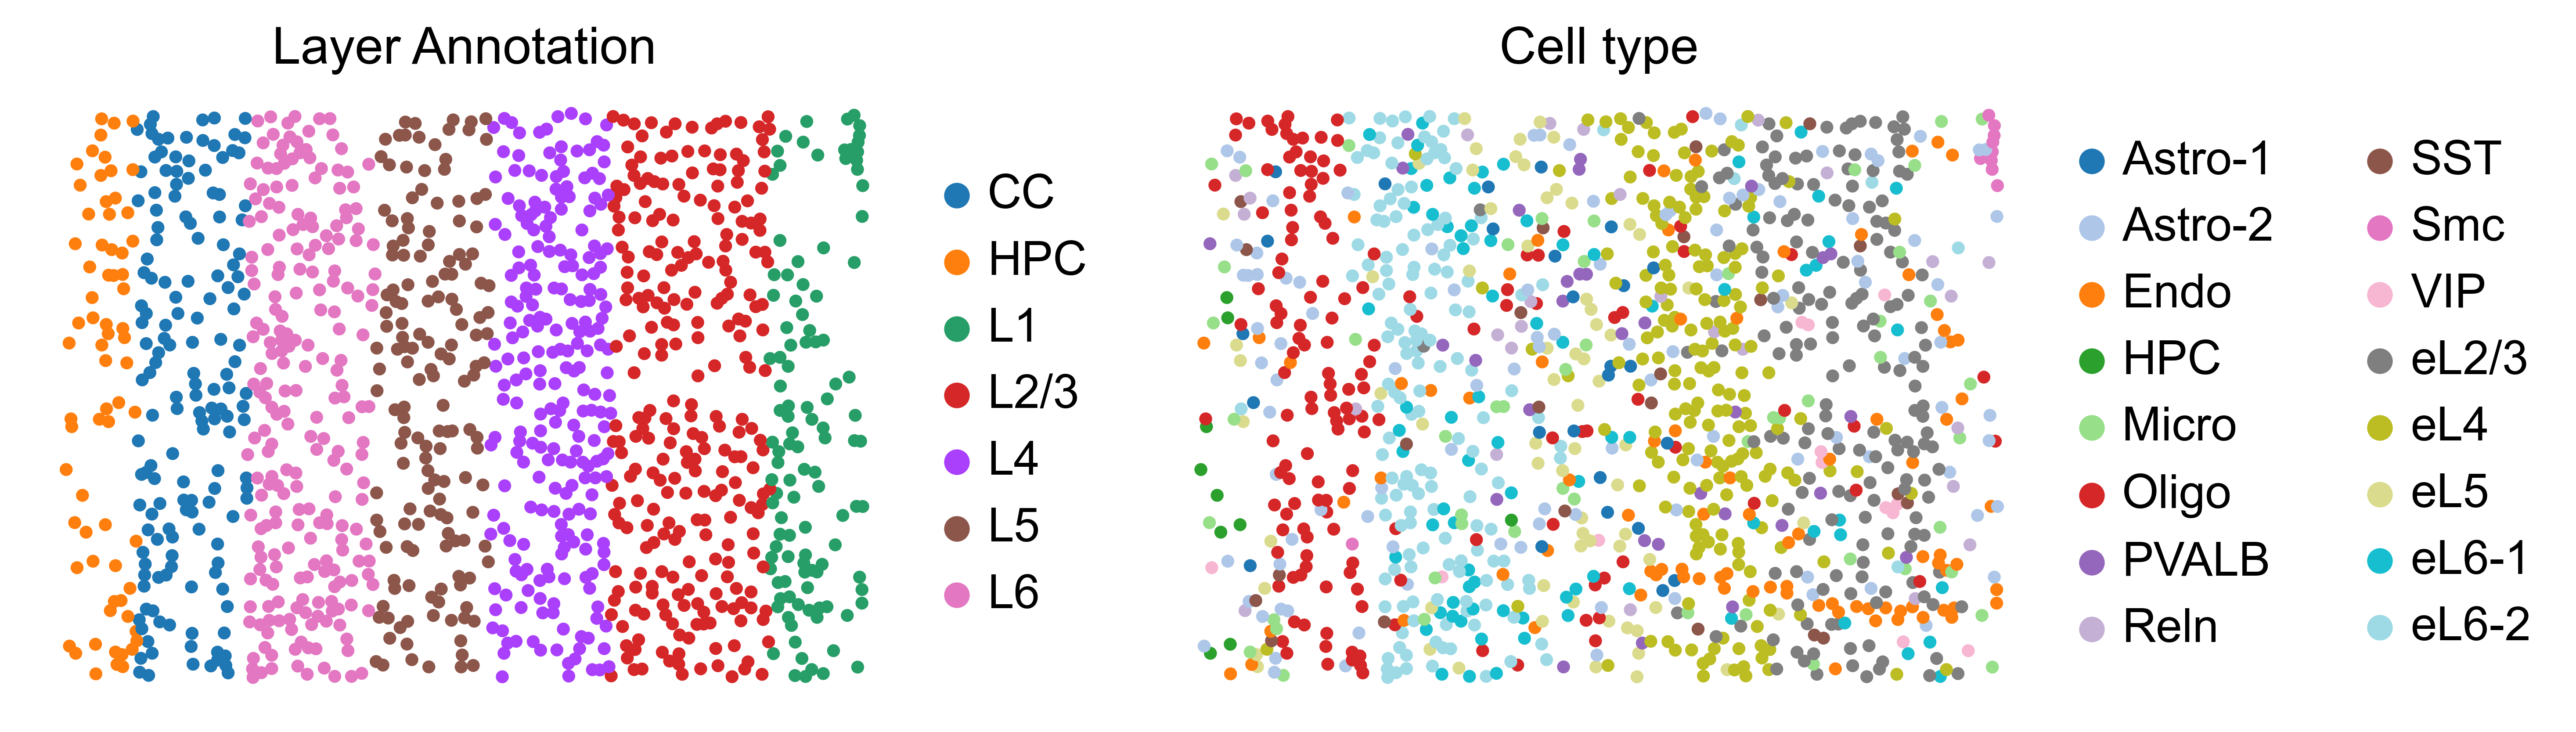

In [9]:
layers = sorted(set(adata.obs['layer']))
layer_color_dict = {layers[k]: sns.color_palette()[k] for k in range(len(layers))}

celltypes = ['Astro-1', 'Astro-2', 'Endo', 'HPC', 'Micro', 'Oligo', 'PVALB', 'Reln', 
             'SST', 'Smc', 'VIP', 'eL2/3', 'eL4', 'eL5', 'eL6-1', 'eL6-2']
ct_colors = ['#1f77b4', '#aec7e8', '#ff7f0e', '#2ca02c', '#98df8a', '#d62728', '#9467bd', '#c5b0d5',
             '#8c564b', '#e377c2', '#f7b6d2', '#7f7f7f', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
ct_color_dict = {celltypes[k]: ct_colors[k] for k in range(len(celltypes))}

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

sc.pl.embedding(adata, basis='spatial', palette=layer_color_dict, color='layer', 
                ax=axes[0], s=50, show=False, frameon=False, title='Layer Annotation')

sc.pl.embedding(adata, basis='spatial', palette=ct_color_dict, color='celltype', 
                ax=axes[1], s=50, show=False, frameon=False, title='Cell type')

plt.tight_layout()
plt.show()

In [10]:
adata = adata[~(adata.obs['celltype'] == 'Smc'), :].copy()
adata

AnnData object with n_obs × n_vars = 1197 × 1020
    obs: 'clusterid', 'celltype', 'layer'
    uns: 'layer_colors', 'celltype_colors'
    obsm: 'spatial'

In [11]:
import sys
sys.path.append("../../")
from codes.model import *

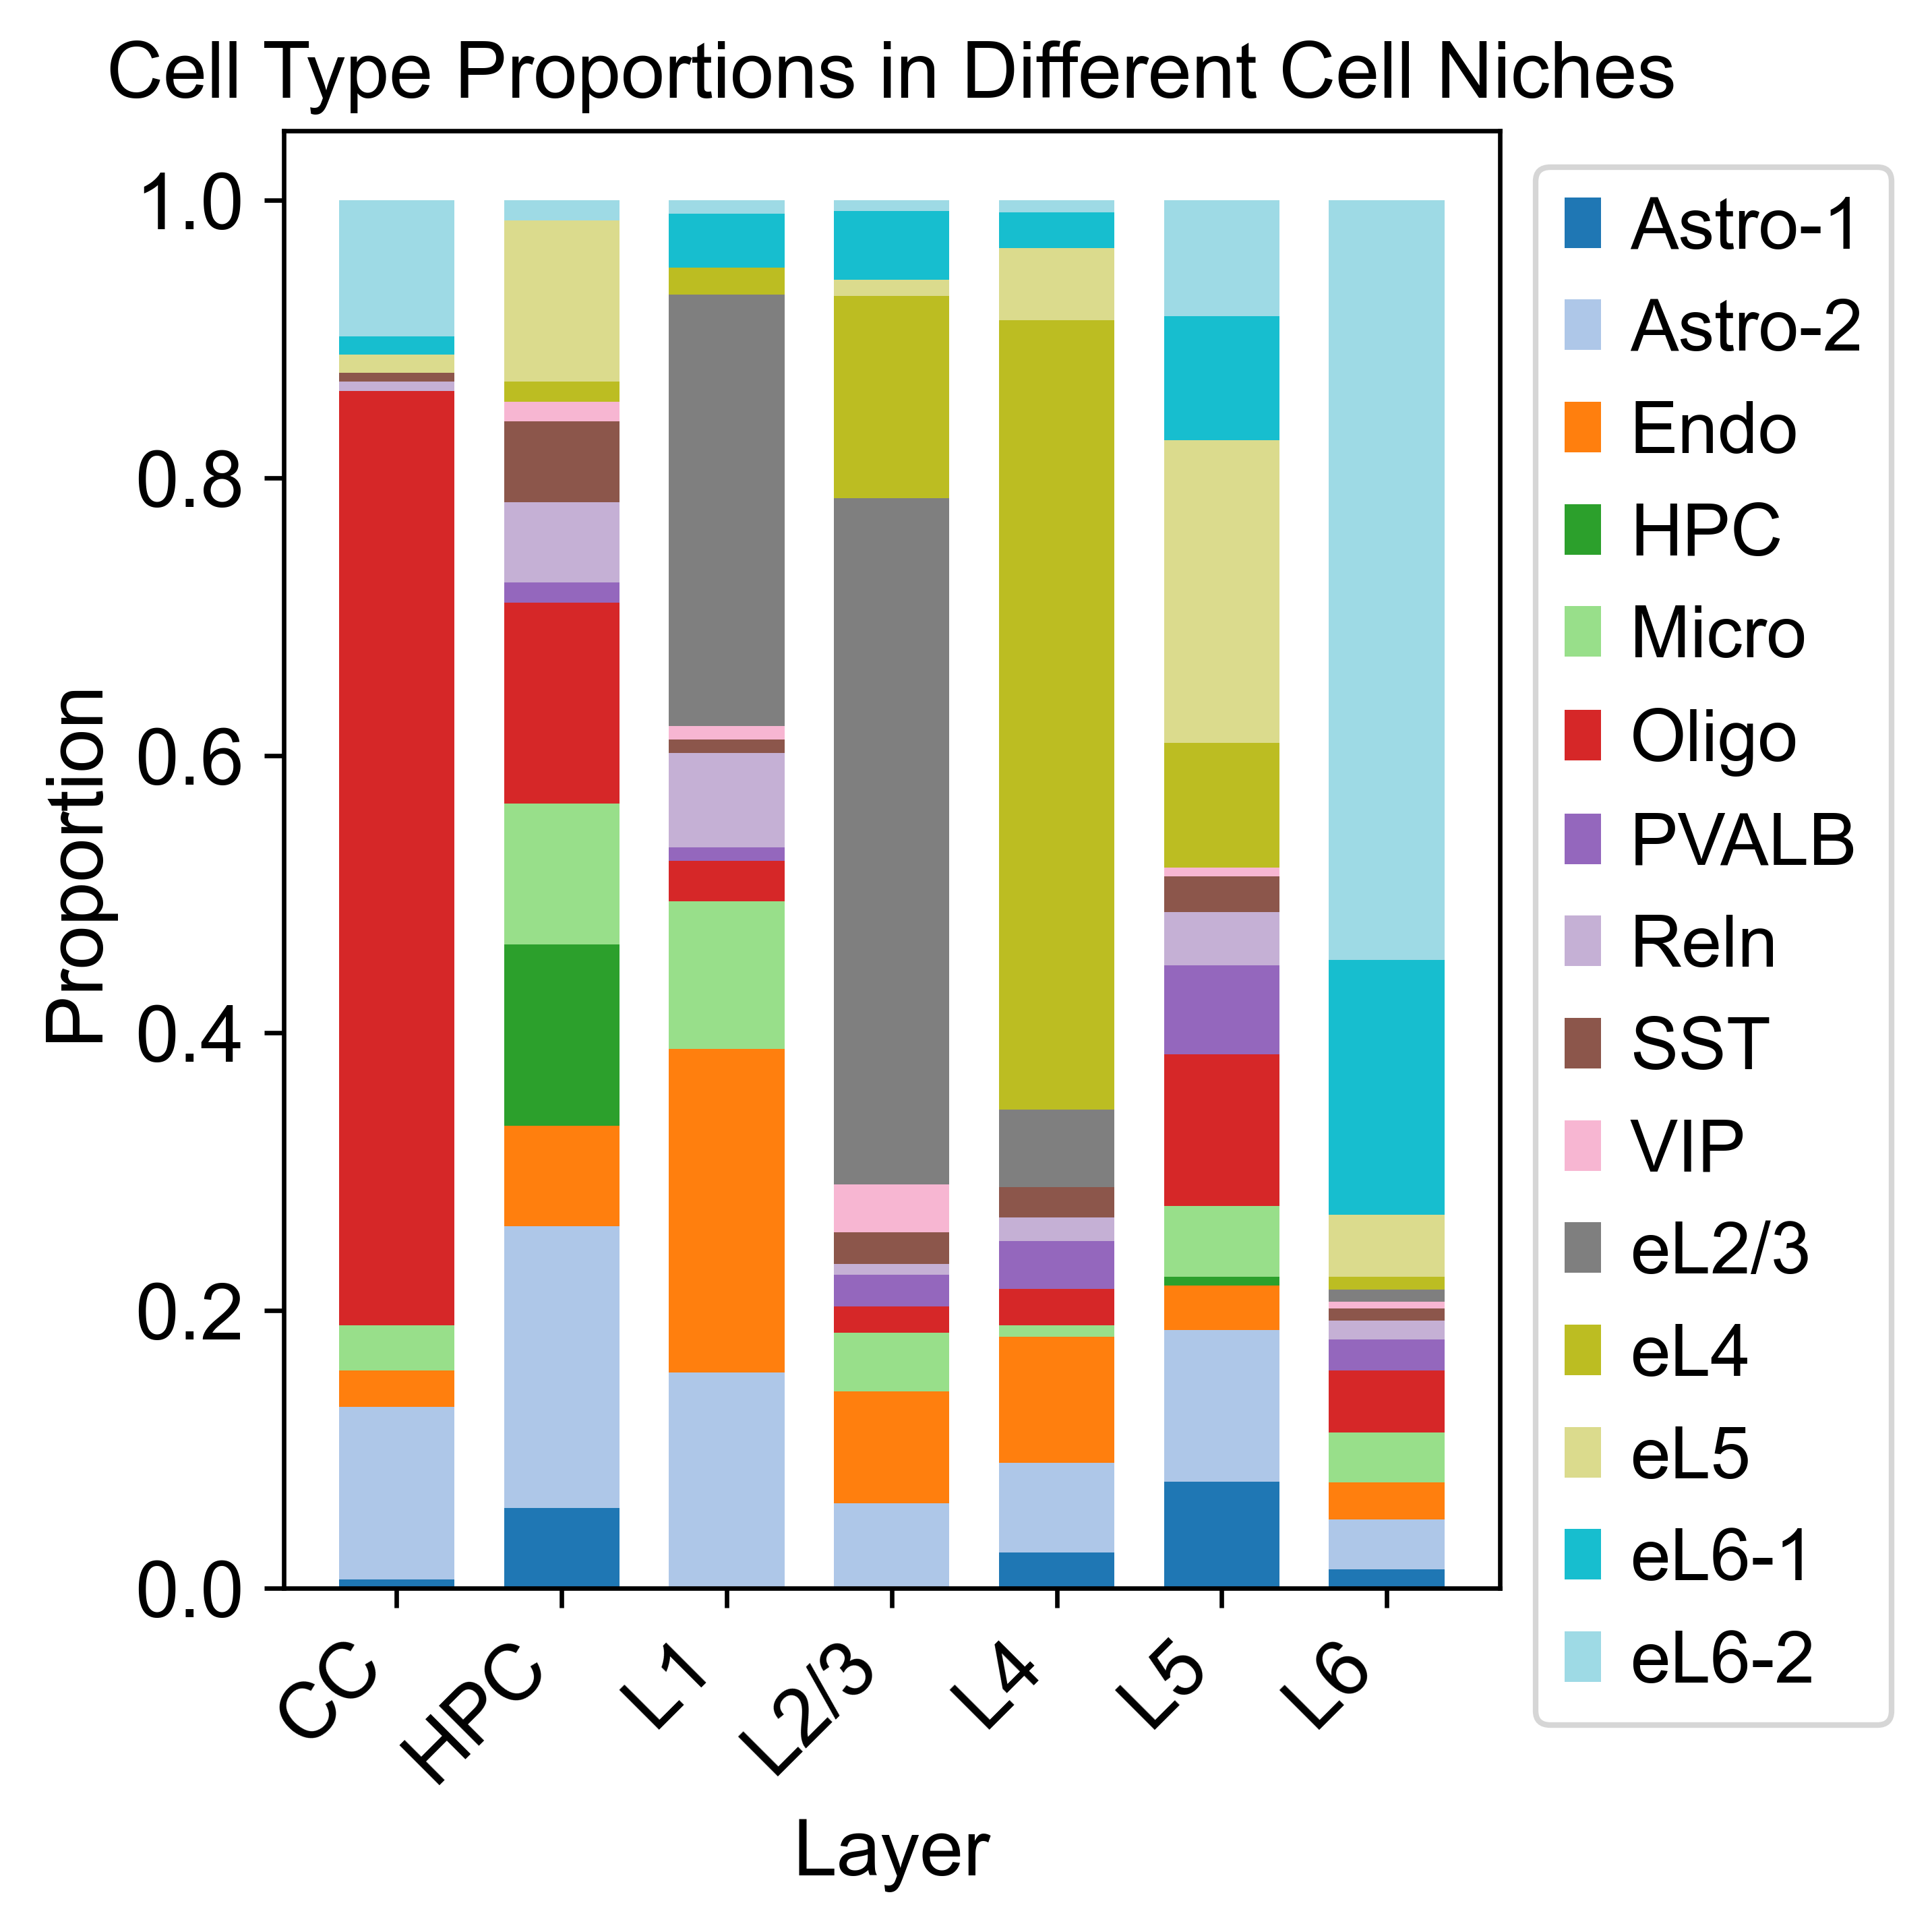

In [16]:
label2onehot_anndata(adata, 'celltype', return_adata=False, sparse=True, verbose=False)

niche_dist, cell_count_niche = calculate_distribution(list(adata.obs['layer'].copy()), 
                                                      list(adata.obs['celltype_idx'].copy()), 
                                                      label_summary=None, 
                                                      n_niches=None, 
                                                      n_celltypes=None, 
                                                      change2str=False, 
                                                      sparse=True)
niche_dist = niche_dist.toarray()

niche_labels = sorted(set(adata.obs['layer']))
ct_labels = sorted(set(adata.obs['celltype']))
celltype_colors = [ct_color_dict[ct] for ct in ct_labels]

fig, ax = plt.subplots(figsize=(5, 5))
bar_width = 0.7
n_niches, n_cell_types = niche_dist.shape

x = np.arange(n_niches)

for j in range(n_cell_types):
    bottom = np.sum(niche_dist[:, :j], axis=1)
    ax.bar(x,                         
           niche_dist[:, j],            
           bottom=bottom,               
           width=bar_width,
           color=celltype_colors[j],
           label=ct_labels[j])

ax.set_ylabel('Proportion')
ax.set_xlabel('Layer')
ax.set_xticks(x)
ax.set_xticklabels(niche_labels, rotation=45, ha='right')

ax.grid(False)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1.0))

plt.title('Cell Type Proportions in Different Cell Niches')
plt.tight_layout()
plt.show()